# Load Data

In [32]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pickle

In [33]:
def load_data(fname):
    f = open(fname, "rb")
    data = pickle.load(f)
    f.close()
    return data

In [34]:
# Loading object file is faster than loading xlsx file
data = load_data("wagedata.dat")

# Select Variable

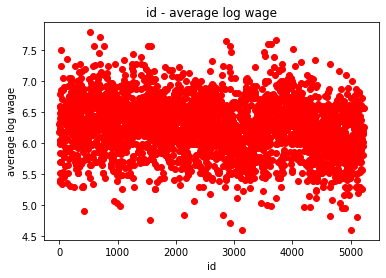

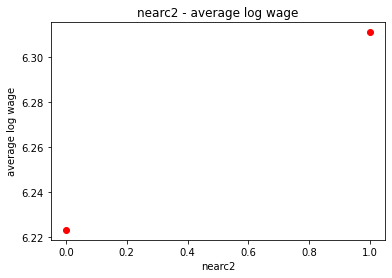

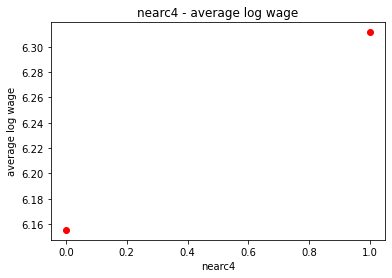

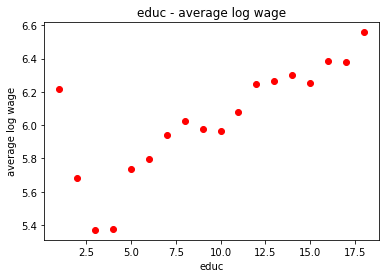

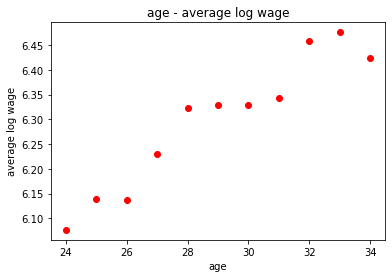

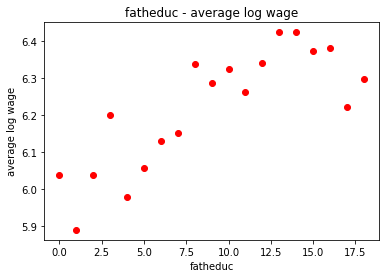

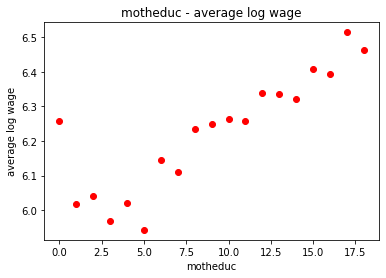

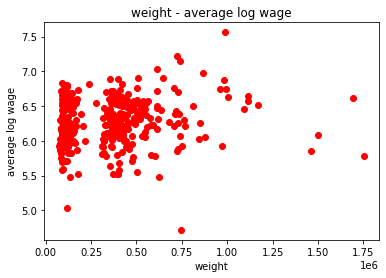

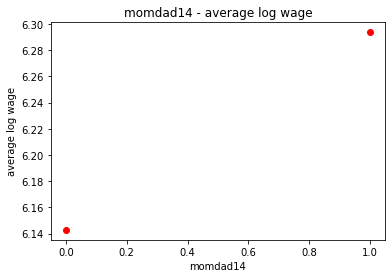

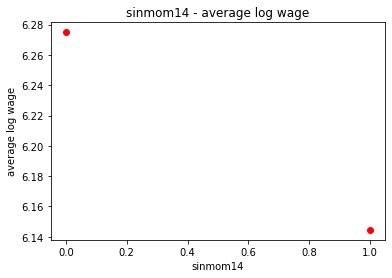

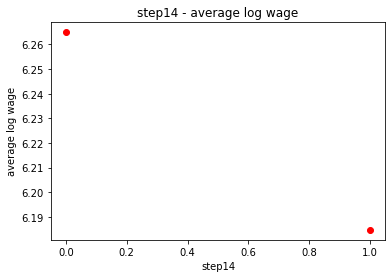

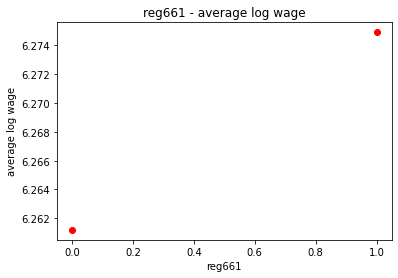

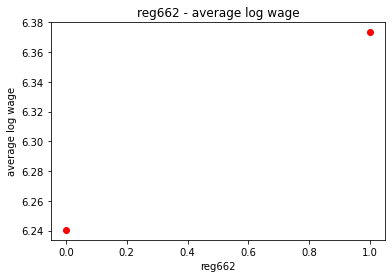

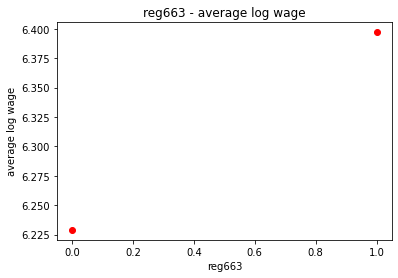

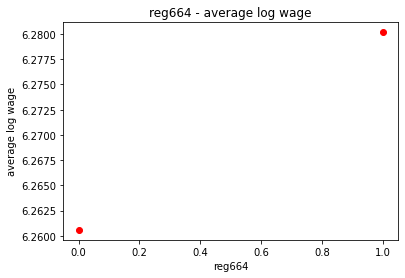

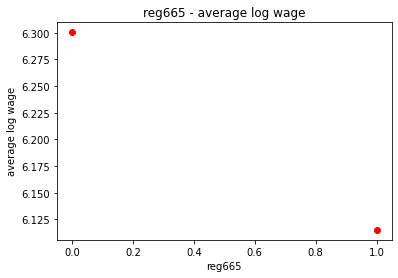

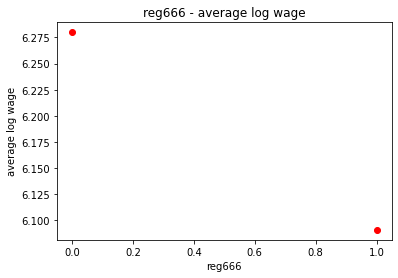

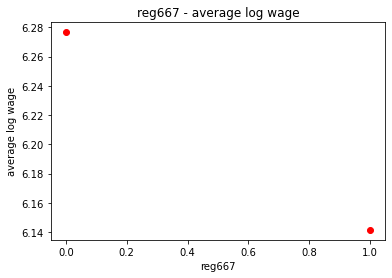

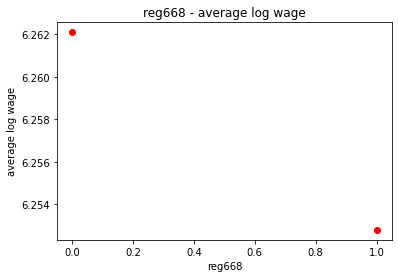

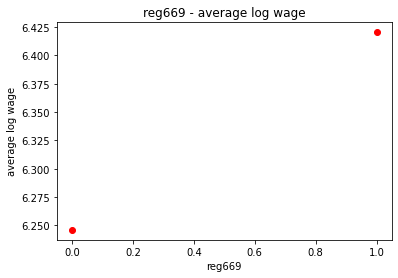

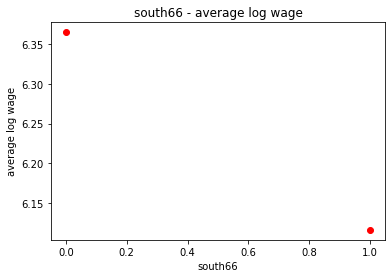

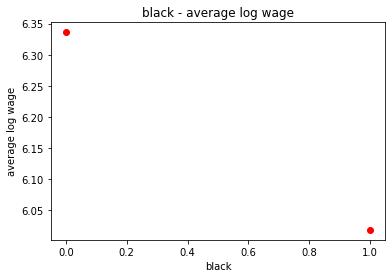

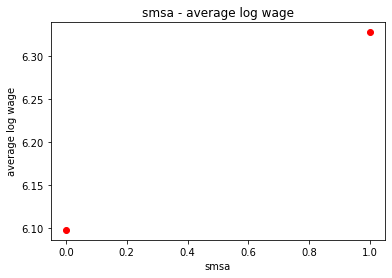

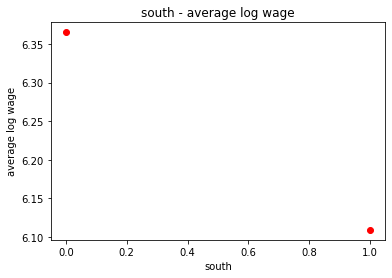

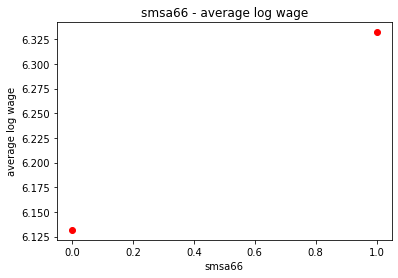

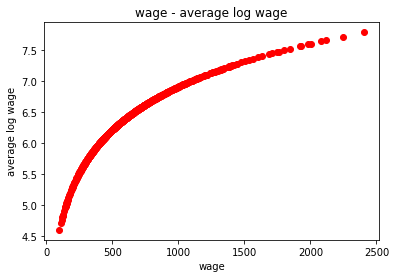

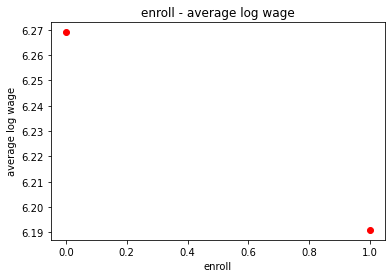

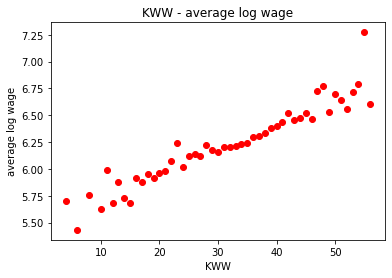

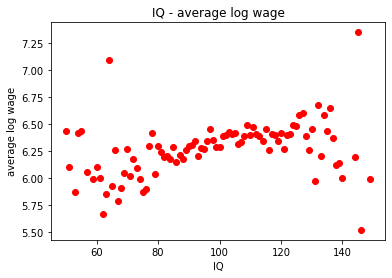

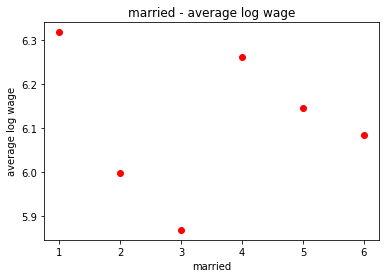

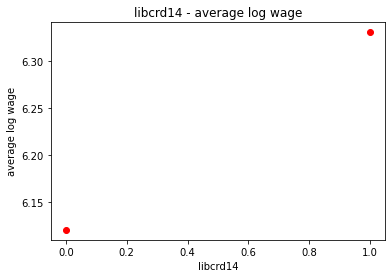

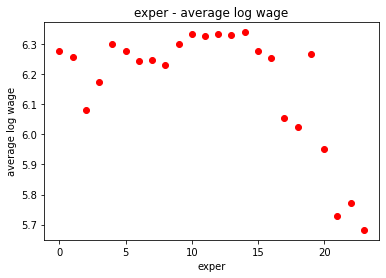

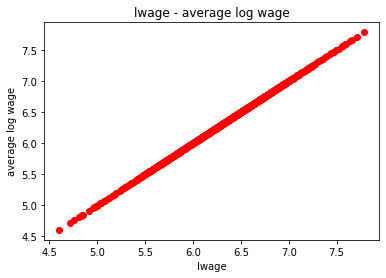

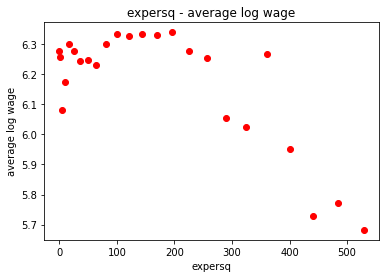

In [35]:
# Display mean of data points
for x in data.columns:
    plt.cla()
    plt.xlabel(x)
    plt.ylabel("average log wage")
    plt.title(x+" - average log wage")
    for dtx in set(data[x]):
        y = data[data[x] == dtx]["lwage"].mean()
        plt.plot(dtx, y, "ro")
    plt.show()

# Train Model

In [36]:
# Variables to train model
data_vars = ["educ","exper","expersq","KWW","black","smsa"]
# Remove NaN rows 
data_ = data[data_vars + ["lwage"]].dropna()
# Just use some variable in data
X_data = data_[data_vars]
# Add ones to first column of matrix
X = np.concatenate((np.ones(shape=(data_.shape[0],1)) , np.array(X_data)), axis=1)
# Log wage is the output
Y = np.array(data_["lwage"]).reshape(len(data_["lwage"]), 1)
# Split data to train and test, shuffle the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

print("X shape: {0} \nY shape: {1}".format(X_train.shape, Y_train.shape))

X shape: (2370, 7) 
Y shape: (2370, 1)


In [37]:
# Caculate inverse of X_T @ X 
X_TX_inverse = np.linalg.inv(X_train.transpose() @ X_train)
# Caculate beta
beta = X_TX_inverse @ X_train.transpose() @ Y_train

# Use library to caculate beta
reg = LinearRegression()
reg.fit(X_train, Y_train)
beta_ = reg.coef_.transpose()
beta_[0,0] += reg.intercept_
print("my beta: \n{0}".format(beta))
print("sklearn beta: \n{0}".format(beta_))

my beta: 
[[ 4.67270214e+00]
 [ 6.12068929e-02]
 [ 7.21499243e-02]
 [-1.92546610e-03]
 [ 7.46589579e-03]
 [-1.90644758e-01]
 [ 1.68083881e-01]]
sklearn beta: 
[[ 4.67270214e+00]
 [ 6.12068929e-02]
 [ 7.21499243e-02]
 [-1.92546610e-03]
 [ 7.46589579e-03]
 [-1.90644758e-01]
 [ 1.68083881e-01]]


In [38]:
# Save our beta to file
np.save("beta.npy", beta)

# Evaluate Model

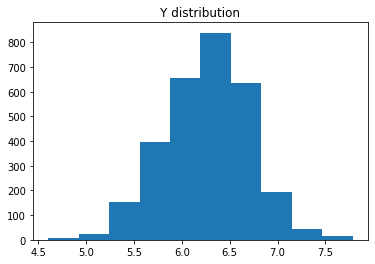

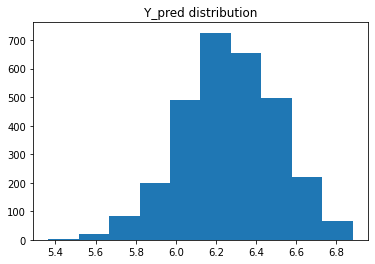

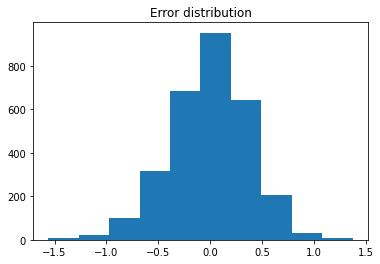

In [39]:
# Display distributions (Create distributions folder before run this code)
plt.hist(Y)
plt.title("Y distribution")
plt.savefig("./distributions/y_dis.png")
plt.show()
plt.hist(X @ beta)
plt.title("Y_pred distribution")
plt.savefig("./distributions/y_pred_dis.png")
plt.show()
plt.hist(Y - X @ beta)
plt.title("Error distribution")
plt.savefig("./distributions/error_dis.png")
plt.show()

In [40]:
# Caculate train error
train_error = np.linalg.norm(Y_train - X_train @ beta)**2 / Y_train.shape[0]
# Caculate test error
test_error = np.linalg.norm(Y_test - X_test @ beta)**2 / Y_test.shape[0]
# Caculate the score to evaluate the effeciency
train_score = 1 - np.linalg.norm(Y_train - X_train @ beta) ** 2 / np.linalg.norm(Y_train - Y_train.mean()) ** 2
test_score = 1 - np.linalg.norm(Y_test - X_test @ beta) ** 2 / np.linalg.norm(Y_test - Y_test.mean()) ** 2
print("Train error: {0}".format(train_error))
print("Test error: {0}".format(test_error))
print("Train R-square: {0}".format(train_score))
print("Test R-square: {0}".format(test_score))

Train error: 0.13929456448807487
Test error: 0.14216896019111375
Train R-square: 0.290918687495065
Test R-square: 0.2441228896100398
